In [1]:
import string
import re 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import csv
import multiprocessing
from multiprocessing import Pool
import nltk

# 1. Get the data

In [ ]:
%%bash
chmod 600 /root/.kaggle/kaggle.json
kaggle datasets download stackoverflow/stacksample
mkdir stacksample
unzip -j stacksample.zip Questions.csv -d stacksample/ 
unzip -j stacksample.zip Tags.csv -d stacksample/
rm stacksample.zip
mkdir data models predictions

# 2. Preparing the data

We begin by loading the data (both the Questions and Tags tables) by chunks. We have followed the same approach as in [Yi Ai's](https://medium.com/@yia333) [Medium post](https://medium.com/hackernoon/auto-generating-tags-for-content-using-amazon-sagemaker-blazingtext-with-fasttext-335c38429de0).

In [2]:
QuestionsFile = "stacksample/Questions.csv"
chunksize = 20000

df = None
for ratings in pd.read_csv(QuestionsFile, names=['id', 'title', 'body'], encoding = 'ISO-8859-1',  header=None , usecols=[0,5,6],error_bad_lines = False, chunksize=chunksize):
    if df is None:
        df = ratings.copy()
    else:
        df.append(ratings)
        
TagsFile = "stacksample/Tags.csv"
chunksize = 20000
df_tags = None
for ratings in pd.read_csv(TagsFile, names=['id', 'tag'], header=None , chunksize=chunksize):
    if df_tags is None:
        df_tags = ratings.copy()
    else:
        df_tags.append(ratings)

# 3. Data Exploration & Visualization

Let's compute statistics over the frequency counts of the *tag* field in the tags dataframe.

In [3]:
df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).to_frame().describe()

,tag
count,3506.000000
mean,5.702510
std,27.213578
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,862.000000


Let's plot a histogram over the top-100 most frequent tags.

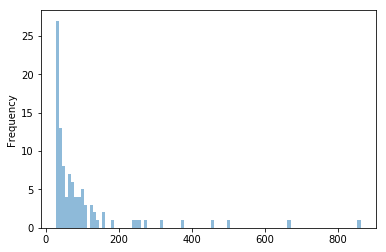

In [4]:
df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).head(100).plot.hist(bins=100, alpha=0.5)

Create a dataframe with tags and frequency counts with the top-100 most frequent tags.

In [5]:
mytags = df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).to_frame().head(100).reset_index()

Let's compute statistics as before, for the subset of the top-100 most frequent tags.

In [6]:
mytags.describe()

,tag
count,100.000000
mean,99.230000
std,128.606506
min,29.000000
25%,37.000000
50%,56.000000
75%,98.250000
max,862.000000


### Wordcloud of the top-100 most frequent tags

In [7]:
d = {}
for a, x in mytags.values:
    d[a] = x

In [8]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate_from_frequencies(frequencies=d)

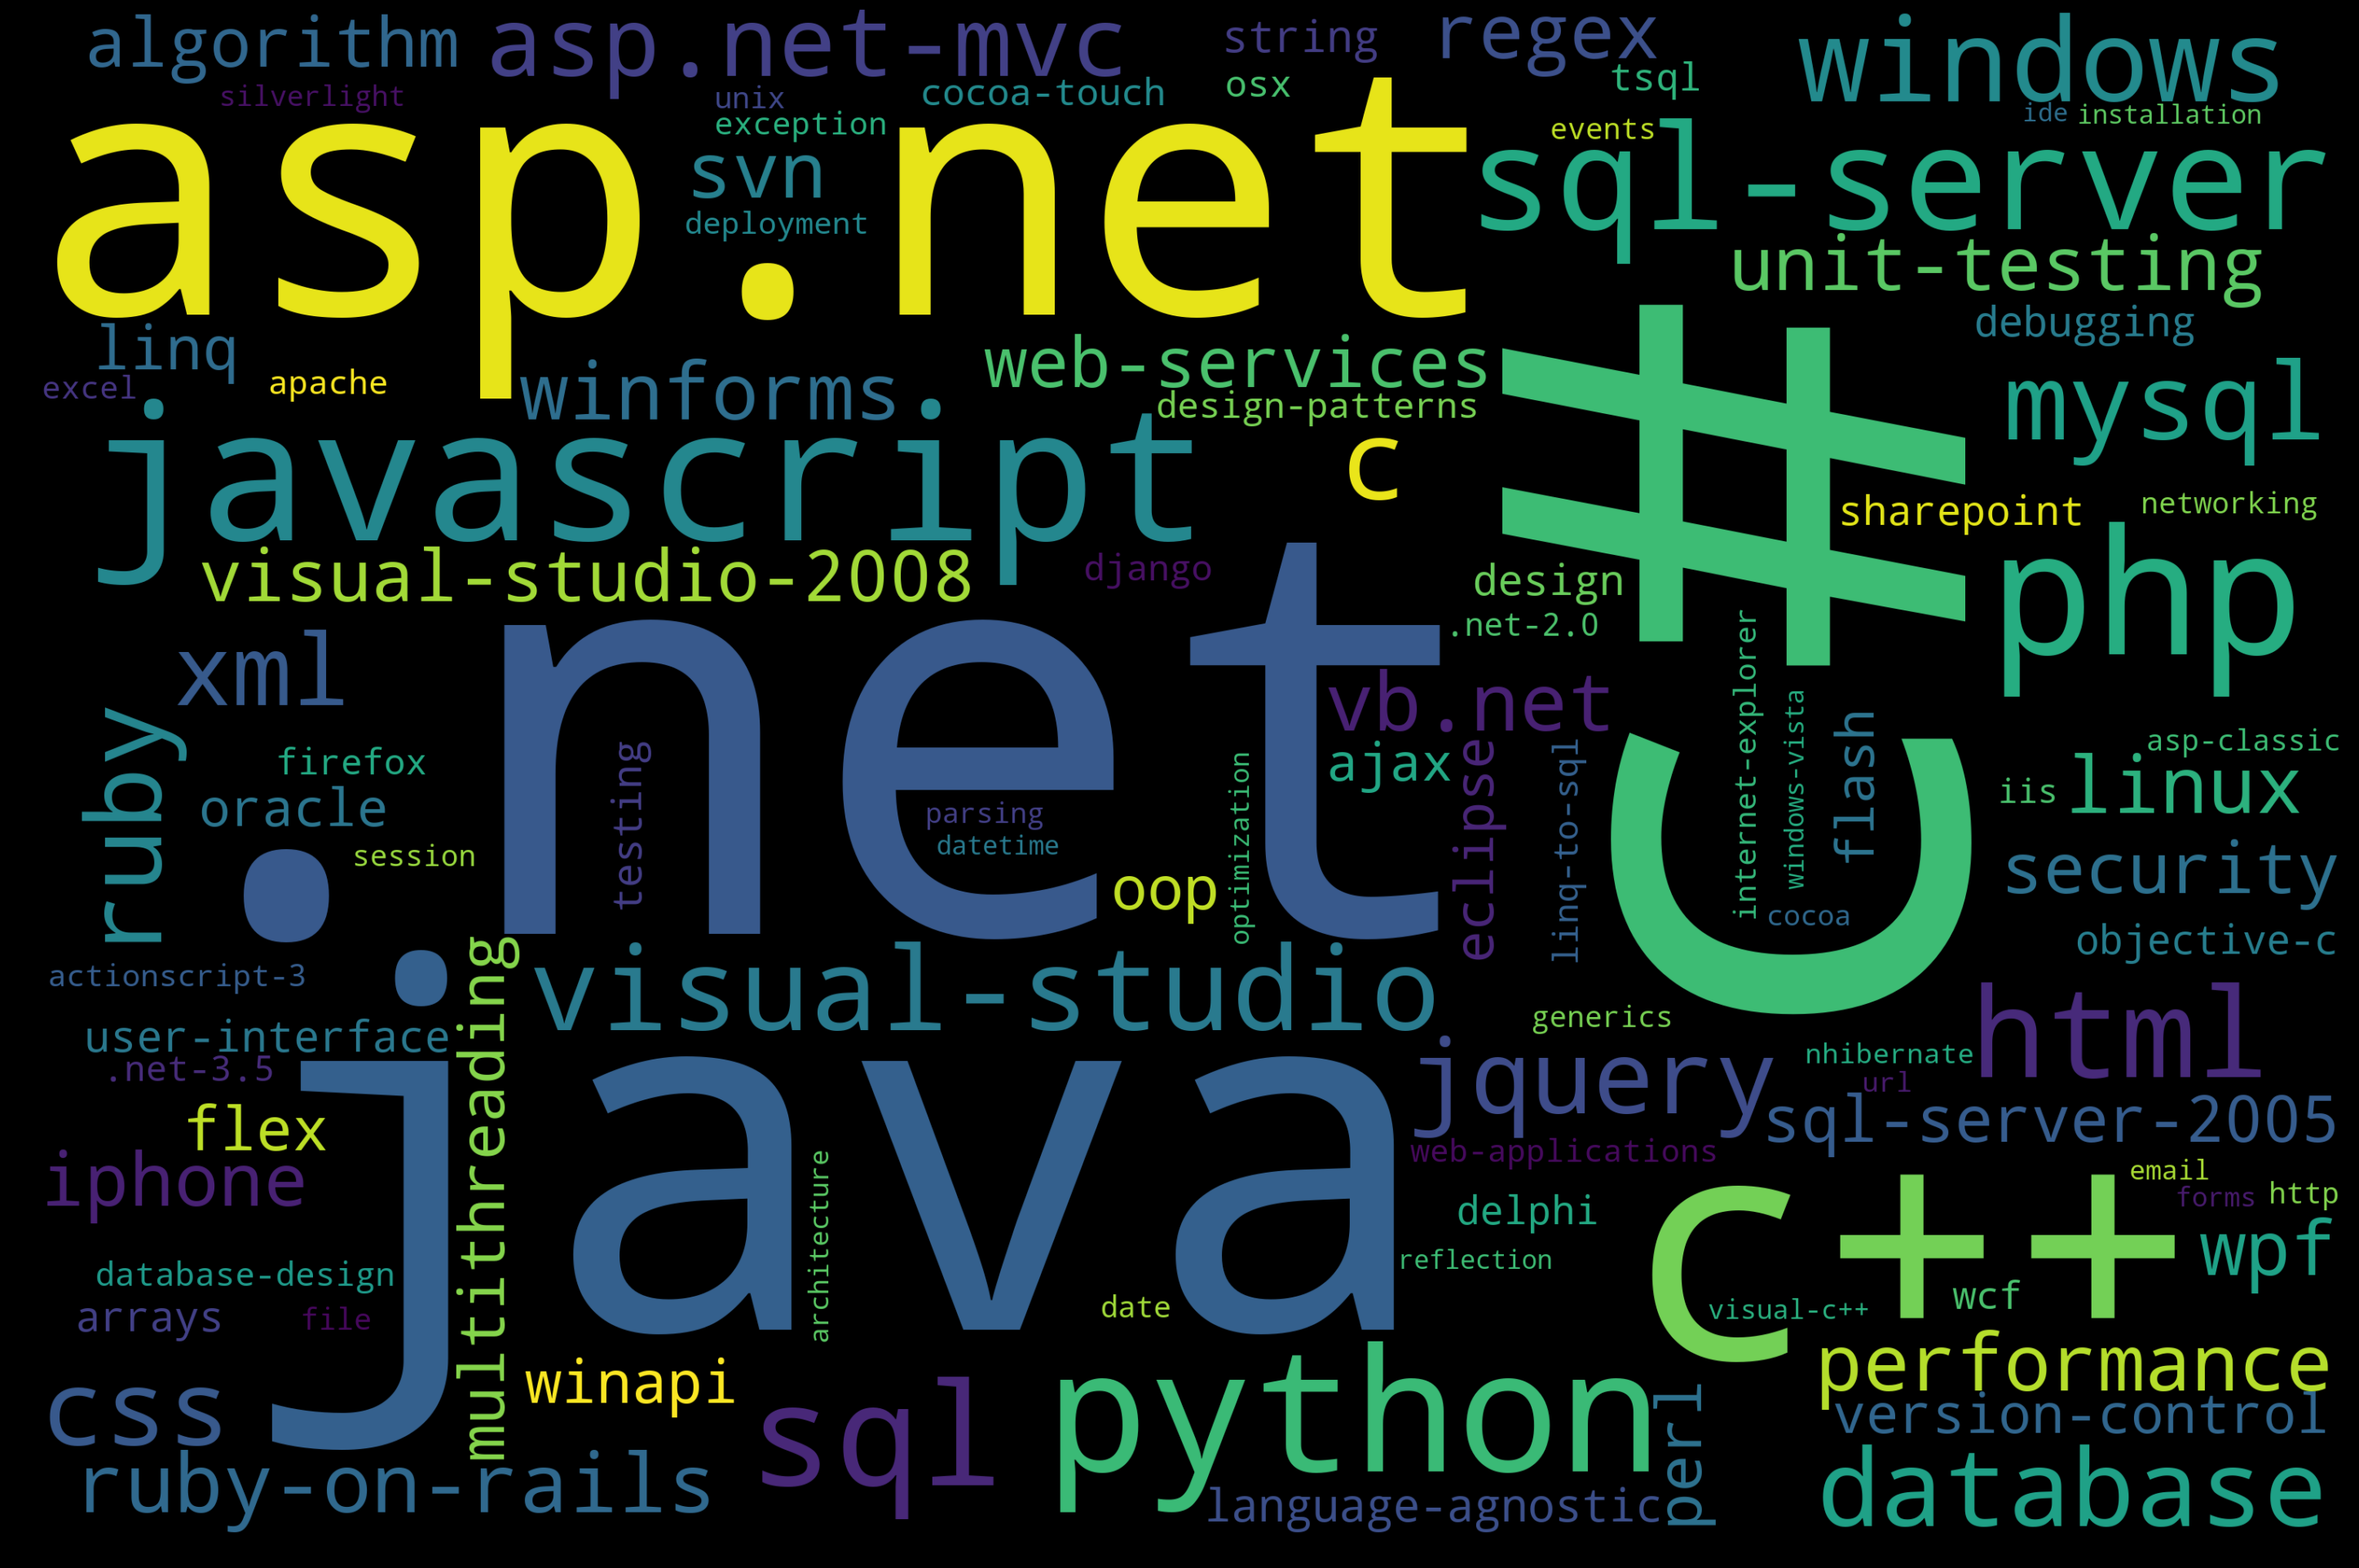

In [9]:
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
fig.savefig('toptags.png', dpi=fig.dpi)

Let's store the top-100 most frequent tags in a list.

In [10]:
topTags = df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).head(100).index.tolist()

Let's filter the tags dataframe based on the previous list.

In [11]:
df_tags = df_tags[df_tags.tag.isin(topTags)]

# 4. Processing the data

For both fastText and BlazingText, the input file has to be formatted in a way that each line contain a single sentence and the corresponding label(s) prefixed by __label__, e.g.  ``__label__database __label__oracle How to edit sessions parameters on Oracle 10g XE?``. Additionally, the input data has to be as clean as possible. The following function generates a preprocessed and clean data after removing HTML tags and unwanted punctuations. 

For both steps, we have followed the same approach as in [Yi Ai's](https://medium.com/@yia333) [Medium post](https://medium.com/hackernoon/auto-generating-tags-for-content-using-amazon-sagemaker-blazingtext-with-fasttext-335c38429de0). The following functions perform the aforementioned steps.

In [12]:
def clean_text(text):
    if not isinstance(text, str): 
        return text
    def cleanhtml(raw_html):
        cleanr = re.compile('<[^>]+>')
        cleantext = re.sub(cleanr, '', raw_html)
        return cleantext
    def replace_link(match):
        return '' if re.match('[a-z]+://', match.group(1)) else match.group(1)
    def removeContractions(raw_text):
        CONTRACTIONS = {"mayn't":"may not", "may've":"may have","isn't":"is not","wasn't":"was not","'ll":" will","'have": "have"}
        raw_text = raw_text.replace("’","'")
        words = raw_text.split()
        reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
        raw_text = " ".join(reformed)
        return raw_text
    text = cleanhtml(text)
    text = removeContractions(text)
    text = re.sub('<pre><code>.*?</code></pre>', '', text)
    text = re.sub('<a[^>]+>(.*)</a>', replace_link, text)
    #Remove hashtags
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", text).split())
    #Remove punctuations
    text = ' '.join(re.sub("[\.\,\(\)\{\}\[\]\`\'\!\?\:\;\-\=]", " ", text).split())
    #text = text.translate(str.maketrans('','',string.punctuation))
    text = text.lower()
    return text

In [13]:
questions = df.values
tags = df_tags.values

all_rows=[]

for index, row in enumerate(questions):
    title = clean_text(row[1])
    tag_ids = [ tag[1] for tag_idx, tag in enumerate(tags) if tag[0]  == row[0] ]
    if(len(tag_ids)>0): 
        all_rows.append({"title":title, "tags":tag_ids})

In [14]:
nltk.download('punkt')

def preprocess(rows,output_file):
    pool = Pool(processes=multiprocessing.cpu_count())
    transformed_rows = pool.map(transform_instance, rows)
    pool.close() 
    pool.join()
    with open(output_file, "w") as txt_file:
        for line in transformed_rows:
            txt_file.write(" ".join(line) + "\n")
            
def transform_instance(row):
    cur_row = []
    label = ["__label__" + str(tag) for tag in row["tags"] if tag]
    label = " ".join(map(str, label))
    cur_row.append(str(label))
    cur_row.extend(nltk.word_tokenize(row["title"]))
    return cur_row

[nltk_data] Downloading package punkt to /Users/pjcv89/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 5. Create training, validation and test sets and store them in local directory

## For fastText and StarSpace models

Apply the previous defined functions and split the data pseudorandomly on train, validation and test sets.

In [15]:
train, valid = train_test_split(all_rows,test_size=0.20,random_state=12345)
valid, test = train_test_split(valid,test_size=0.50,random_state=12345)

preprocess(train, 'data/train')    
preprocess(valid, 'data/valid')
preprocess(test, 'data/test')

In [16]:
pdf_test = pd.DataFrame(test).explode('tags')

# 6. Building and Training the Models

Before training and using the models for predictions, let's take our test set and make a list with the true tags for each instance in the set. We are going to collect predictions for each model and append a new column to this dataframe with the corresponding predictions each time.

In [17]:
indexes = pdf_test.title.unique()
grouped = pdf_test.groupby('title').apply(lambda x: list(x.tags)).to_frame().reindex(indexes).reset_index().rename(columns={0: "true"})
grouped['n_tags'] = grouped['true'].apply(lambda x: len(x))

Let's take a small sample. This will be our working sample to show predictions for each model from now on.

In [18]:
grouped[grouped['n_tags']>2].sample(15,random_state=12345).drop(columns='n_tags')

,title,true
297,how can i add sessions to my perl web app,"[perl, web-applications, session]"
313,parsing exact dates in c# shouldn t force you ...,"[c#, .net, datetime, parsing]"
175,is there a perl equivalent of python s re find...,"[python, regex, perl]"
457,persistence solutions for c++ with a sql database,"[c++, sql, database]"
494,what s a good way to check if two datetimes ar...,"[sql, sql-server, tsql, datetime]"
448,create a search engine with sql 2000 and asp n...,"[c#, asp.net, sql-server]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]"
165,asp net iis service unavailable,"[asp.net, .net, iis]"
528,dragging an image in wpf,"[.net, wpf, user-interface]"
37,unit tests framework for databases,"[sql-server, database, unit-testing]"


## 6.1 fastText

For the fastText model to use as baseline, we use the same settings as reported in [Yi Ai's](https://medium.com/@yia333) [Medium post](https://medium.com/hackernoon/auto-generating-tags-for-content-using-amazon-sagemaker-blazingtext-with-fasttext-335c38429de0). In this case, for quick training and predicting, we can use the data stored locally and use fastText locally. Note that if we would like to deploy the model for predictions via Amazon SageMaker and BlazingText, we can do in the same way he reports in the post.

Train the fastText model in local mode.

In [19]:
import fasttext
ft_baseline = fasttext.train_supervised(input="data/train", lr=0.1, epoch=10, wordNgrams=1,dim=100)

Note that we can compute average *precision@k* and *recall@k* over the test set using fastText built-in tool for metrics.

In [20]:
[ft_baseline.test("data/test",k=i) for i in range(1,5)]

[(592, 0.3918918918918919, 0.22924901185770752),
 (592, 0.26013513513513514, 0.30434782608695654),
 (592, 0.1981981981981982, 0.34782608695652173),
 (592, 0.16047297297297297, 0.37549407114624506)]

If we want to persist this model we can do it by using its *save_model* method.

In [21]:
ft_baseline.save_model("models/ft_baseline.bin")
del ft_baseline

And we can load it using fastText's load_model function.

In [22]:
ft_baseline = fasttext.load_model("models/ft_baseline.bin")

Let's define a function to perform predictions and get the top-3 most probable tags for each instance of the test set.

In [23]:
def get_FTpredictions(model,sentence,threshold=None,k=3):
    if threshold:
        labels, probs = model.predict(sentence.lower(),k=k)
        candidates = [labels[index]  for index in range(0,k) if probs[index] >= threshold]
    else:
        candidates = model.predict(sentence.lower(),k=k)[0]
    output = [candidate.replace("__label__","") for candidate in candidates]
    return output

Apply the previous function over the *title* field in the test set.

In [24]:
grouped['ft_baseline'] = grouped.title.apply(lambda sentence: get_FTpredictions(ft_baseline,sentence))

Let's take a look to predictions on our small sample.

In [25]:
grouped[grouped['n_tags']>2].sample(15,random_state=12345).drop(columns='n_tags')

,title,true,ft_baseline
297,how can i add sessions to my perl web app,"[perl, web-applications, session]","[c#, .net, asp.net]"
313,parsing exact dates in c# shouldn t force you ...,"[c#, .net, datetime, parsing]","[c#, .net, c++]"
175,is there a perl equivalent of python s re find...,"[python, regex, perl]","[python, c++, java]"
457,persistence solutions for c++ with a sql database,"[c++, sql, database]","[c++, sql, sql-server]"
494,what s a good way to check if two datetimes ar...,"[sql, sql-server, tsql, datetime]","[c++, java, python]"
448,create a search engine with sql 2000 and asp n...,"[c#, asp.net, sql-server]","[asp.net, .net, sql-server]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]"
165,asp net iis service unavailable,"[asp.net, .net, iis]","[asp.net, asp.net-mvc, .net]"
528,dragging an image in wpf,"[.net, wpf, user-interface]","[.net, c#, javascript]"
37,unit tests framework for databases,"[sql-server, database, unit-testing]","[java, c++, php]"


##  Hyperparameter autotuning

In [30]:
! fastText/build/fasttext supervised -input data/train -autotune-validation data/valid -output models/ft_tuned -dim 100 -autotune-duration 900

Progress: 100.0% Trials:  208 Best score:  0.501575 ETA:   0h 0m 0s14m33s14m29s13m36s0.211720 ETA:   0h13m27sm 8s  0h12m 5sh11m58sh11m49s41s84 Best score:  0.481411 ETA:   0h10m47sh10m35s 9m40s8m45s0h 8m44s8m37sh 8m35s 7m43s 111 Best score:  0.482672 ETA:   0h 7m40sh 5m 6s0.500315 ETA:   0h 4m 7s0h 3m35s3m26s  0h 3m16s 2m59s0h 2m29s ETA:   0h 2m 0s 1m46s ETA:   0h 1m30s  0h 0m44sh 0m 4s 0m 3s
Training again with best arguments
Read 0M words
Number of words:  5631
Number of labels: 100
Progress: 100.0% words/sec/thread:   71857 lr:  0.000000 avg.loss:  1.967813 ETA:   0h 0m 0s  0h 0m 5s


In [31]:
ft_tuned = fasttext.load_model("models/ft_tuned.bin")

In [32]:
[ft_tuned.test("data/test",k=i) for i in range(1,5)]

[(592, 0.6418918918918919, 0.37549407114624506),
 (592, 0.44594594594594594, 0.5217391304347826),
 (592, 0.3355855855855856, 0.5889328063241107),
 (592, 0.27153716216216217, 0.6353754940711462)]

In [33]:
grouped['ft_tuned'] = grouped.title.apply(lambda sentence: get_FTpredictions(ft_tuned,sentence))

In [34]:
grouped[grouped['n_tags']>2].sample(20,random_state=12345).drop(columns='n_tags')

,title,true,ft_baseline,ft_tuned
297,how can i add sessions to my perl web app,"[perl, web-applications, session]","[c#, .net, asp.net]","[perl, session, web-applications]"
313,parsing exact dates in c# shouldn t force you ...,"[c#, .net, datetime, parsing]","[c#, .net, c++]","[datetime, wpf, tsql]"
175,is there a perl equivalent of python s re find...,"[python, regex, perl]","[python, c++, java]","[python, perl, regex]"
457,persistence solutions for c++ with a sql database,"[c++, sql, database]","[c++, sql, sql-server]","[database, sql-server, sql]"
494,what s a good way to check if two datetimes ar...,"[sql, sql-server, tsql, datetime]","[c++, java, python]","[date, sql-server, tsql]"
448,create a search engine with sql 2000 and asp n...,"[c#, asp.net, sql-server]","[asp.net, .net, sql-server]","[sql-server, asp.net, c#]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]","[sql-server, sql, sql-server-2005]"
165,asp net iis service unavailable,"[asp.net, .net, iis]","[asp.net, asp.net-mvc, .net]","[asp.net, iis, web-services]"
528,dragging an image in wpf,"[.net, wpf, user-interface]","[.net, c#, javascript]","[wpf, silverlight, visual-c++]"
37,unit tests framework for databases,"[sql-server, database, unit-testing]","[java, c++, php]","[unit-testing, database, testing]"


## 6.2 StarSpace

In [35]:
! StarSpace/starspace train -trainFile data/train -validationFile data/valid -useWeight 0 -model models/ss_unweighted -loss softmax -lr 0.1 -epoch 10 -batchSize 1 -ngrams 1 -adagrad 0

Arguments: 
lr: 0.1
dim: 100
epoch: 10
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: softmax
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 1
thread: 10
minCount: 1
minCountLabel: 1
label: __label__
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 0
trainMode: 0
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 0
weightSep: :
Start to initialize starspace model.
Build dict from input file : data/train
Read 0M words
Number of words in dictionary:  5630
Number of labels in dictionary: 100
Loading data from file : data/train
Total number of examples loaded : 4730
Loading data from file : data/valid
Total number of examples loaded : 591
Training epoch 0: 0.1 0.01
Epoch: 99.8%  lr: 0.090000  loss: 3.686387  eta: <1min   tot: 0h0m0s  (10.0%)
 ---+++                Epoch    0 Train error : 3.67185760 +++--- ☃
Epoch: 98.5%  lr: 0.000000  loss: 3.490637  eta: <1min   tot: 0h0m0s  (9.8%)
Validation error: 3.585

In [36]:
! StarSpace/starspace test -model models/ss_unweighted.tsv -testFile data/test -predictionFile predictions/rawpreds -K 3

Arguments: 
lr: 0.01
dim: 100
epoch: 5
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: hinge
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 5
thread: 10
minCount: 1
minCountLabel: 1
label: __label__
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 1
trainMode: 0
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 0
weightSep: :
Start to load a trained embedding model in tsv format.
Loading dict from model file : models/ss_unweighted.tsv
Number of words in dictionary:  5630
Number of labels in dictionary: 100
Loading model from file models/ss_unweighted.tsv
Model loaded.
Loading data from file : data/test
Total number of examples loaded : 592
Predictions use 100 known labels.
Evaluation Metrics : 
hit@1: 0.182432 hit@10: 0.574324 hit@20: 0.72973 hit@50: 0.898649 mean ranks : 17.1419 Total examples : 592


In [37]:
%%bash
cd predictions   
grep -A3 Predictions: rawpreds | awk -F'__label__' '{print $2}' | awk -v RS= '{gsub(/\n/, " ")}3'  > preds 
awk '/LHS:/ {for(i=1; i<=1; i++) {getline; print}}' rawpreds > lhss 
paste -d ',' lhss preds > cleanpreds && rm lhss preds

In [38]:
ss_predictions = pd.read_csv('predictions/cleanpreds',sep=',',names=['title','ss_unweighted'])
ss_predictions['title'] = ss_predictions['title'].str.strip()
ss_predictions['ss_unweighted'] = ss_predictions['ss_unweighted'].str.strip().apply(lambda x: x.split('  '))

In [39]:
grouped = grouped.merge(ss_predictions.drop(columns=['title']),left_index=True,right_index=True)

In [40]:
grouped[grouped['n_tags']>2].sample(20,random_state=12345).drop(columns='n_tags')

,title,true,ft_baseline,ft_tuned,ss_unweighted
297,how can i add sessions to my perl web app,"[perl, web-applications, session]","[c#, .net, asp.net]","[perl, session, web-applications]","[arrays, optimization, c++]"
313,parsing exact dates in c# shouldn t force you ...,"[c#, .net, datetime, parsing]","[c#, .net, c++]","[datetime, wpf, tsql]","[c#, .net, vb.net]"
175,is there a perl equivalent of python s re find...,"[python, regex, perl]","[python, c++, java]","[python, perl, regex]","[perl, python, parsing]"
457,persistence solutions for c++ with a sql database,"[c++, sql, database]","[c++, sql, sql-server]","[database, sql-server, sql]","[c, string, generics]"
494,what s a good way to check if two datetimes ar...,"[sql, sql-server, tsql, datetime]","[c++, java, python]","[date, sql-server, tsql]","[eclipse, svn, unit-testing]"
448,create a search engine with sql 2000 and asp n...,"[c#, asp.net, sql-server]","[asp.net, .net, sql-server]","[sql-server, asp.net, c#]","[perl, regex, java]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]","[sql-server, sql, sql-server-2005]","[sql, sql-server, sql-server-2005]"
165,asp net iis service unavailable,"[asp.net, .net, iis]","[asp.net, asp.net-mvc, .net]","[asp.net, iis, web-services]","[asp.net, iis, asp.net-mvc]"
528,dragging an image in wpf,"[.net, wpf, user-interface]","[.net, c#, javascript]","[wpf, silverlight, visual-c++]","[linq-to-sql, sql-server, sql]"
37,unit tests framework for databases,"[sql-server, database, unit-testing]","[java, c++, php]","[unit-testing, database, testing]","[unit-testing, testing, performance]"


## Label weights 

In [41]:
df_labels = pd.read_csv('data/train',names=['single'])

In [42]:
df_labels.head(10)

,single
0,__label__user-interface which factor gui tutor...
1,__label__python how are post and get variables...
2,__label__sql __label__sql-server semi tricky s...
3,__label__regex regex in vb6
4,__label__database-design should i have a dedic...
5,__label__delphi how to track down tricky memor...
6,__label__html can you nest html forms
7,__label__language-agnostic what is an ideal va...
8,__label__wpf reset expander to default collaps...
9,__label__sql-server __label__excel how should ...


In [43]:
df_labels['text'] = df_labels['single'].apply(lambda x: x.split(" ")) \
.apply(lambda line: list(filter(lambda x: "__label__" not in x, line))) \
.apply(lambda line: ' '.join(line))

df_labels['single'] = df_labels['single'].apply(lambda x: x.split(" ")) \
.apply(lambda line: list(filter(lambda x: "__label__" in x, line))).to_frame()

In [44]:
df_labels.head(10)

,single,text
0,[__label__user-interface],which factor gui tutorial/example app
1,[__label__python],how are post and get variables handled in python
2,"[__label__sql, __label__sql-server]",semi tricky sql query
3,[__label__regex],regex in vb6
4,[__label__database-design],should i have a dedicated primary key field
5,[__label__delphi],how to track down tricky memory leak with fastmm
6,[__label__html],can you nest html forms
7,[__label__language-agnostic],what is an ideal variable naming convention fo...
8,[__label__wpf],reset expander to default collapse behavior
9,"[__label__sql-server, __label__excel]",how should i import highly formatted data from...


In [45]:
df_labels['n_labels'] = df_labels['single'].apply(lambda x: len(x))
df_labels = df_labels['single'].apply(pd.Series).add_prefix('label_').merge(df_labels.drop(columns=['single']),left_index=True,right_index=True)

In [46]:
df_labels.head(10)

,label_0,label_1,label_2,label_3,label_4,text,n_labels
0,__label__user-interface,NaN,NaN,NaN,NaN,which factor gui tutorial/example app,1
1,__label__python,NaN,NaN,NaN,NaN,how are post and get variables handled in python,1
2,__label__sql,__label__sql-server,NaN,NaN,NaN,semi tricky sql query,2
3,__label__regex,NaN,NaN,NaN,NaN,regex in vb6,1
4,__label__database-design,NaN,NaN,NaN,NaN,should i have a dedicated primary key field,1
5,__label__delphi,NaN,NaN,NaN,NaN,how to track down tricky memory leak with fastmm,1
6,__label__html,NaN,NaN,NaN,NaN,can you nest html forms,1
7,__label__language-agnostic,NaN,NaN,NaN,NaN,what is an ideal variable naming convention fo...,1
8,__label__wpf,NaN,NaN,NaN,NaN,reset expander to default collapse behavior,1
9,__label__sql-server,__label__excel,NaN,NaN,NaN,how should i import highly formatted data from...,2


In [47]:
def make_weights(n_labels):
    if n_labels == 1:
        weights = [1.0,0,0,0,0]
    elif n_labels == 2:
        weights = [0.75,0.25,0,0,0]
    elif n_labels == 3:
        weights = [0.50,0.30,0.20,0.0]
    elif n_labels == 4:
        weights = [0.40,0.25,0.20,0.15,0]
    elif n_labels == 5:
        weights = [0.30,0.25,0.20,0.15,0.10]
    return [":"+str(i) for i in weights]

In [48]:
df_labels = df_labels['n_labels'].apply(lambda n: make_weights(n)).apply(pd.Series).add_prefix('weight_') \
.merge(df_labels.drop(columns='n_labels'),left_index=True,right_index=True)

In [49]:
df_labels['label_0'] = df_labels['label_0']+df_labels['weight_0']
df_labels['label_1'] = df_labels['label_1']+df_labels['weight_1']
df_labels['label_2'] = df_labels['label_2']+df_labels['weight_2']
df_labels['label_3'] = df_labels['label_3']+df_labels['weight_3']
df_labels['label_4'] = df_labels['label_4']+df_labels['weight_4']

In [50]:
df_labels = df_labels[df_labels.columns.drop(list(df_labels.filter(regex='weight')))]

In [51]:
df_labels.head(10)

,label_0,label_1,label_2,label_3,label_4,text
0,__label__user-interface:1.0,NaN,NaN,NaN,NaN,which factor gui tutorial/example app
1,__label__python:1.0,NaN,NaN,NaN,NaN,how are post and get variables handled in python
2,__label__sql:0.75,__label__sql-server:0.25,NaN,NaN,NaN,semi tricky sql query
3,__label__regex:1.0,NaN,NaN,NaN,NaN,regex in vb6
4,__label__database-design:1.0,NaN,NaN,NaN,NaN,should i have a dedicated primary key field
5,__label__delphi:1.0,NaN,NaN,NaN,NaN,how to track down tricky memory leak with fastmm
6,__label__html:1.0,NaN,NaN,NaN,NaN,can you nest html forms
7,__label__language-agnostic:1.0,NaN,NaN,NaN,NaN,what is an ideal variable naming convention fo...
8,__label__wpf:1.0,NaN,NaN,NaN,NaN,reset expander to default collapse behavior
9,__label__sql-server:0.75,__label__excel:0.25,NaN,NaN,NaN,how should i import highly formatted data from...


In [52]:
df_labels = df_labels[df_labels.columns].apply(lambda x: ' '.join(x.dropna().astype(str)),axis=1).to_frame()

In [53]:
df_labels.head(10)

,0
0,__label__user-interface:1.0 which factor gui t...
1,__label__python:1.0 how are post and get varia...
2,__label__sql:0.75 __label__sql-server:0.25 sem...
3,__label__regex:1.0 regex in vb6
4,__label__database-design:1.0 should i have a d...
5,__label__delphi:1.0 how to track down tricky m...
6,__label__html:1.0 can you nest html forms
7,__label__language-agnostic:1.0 what is an idea...
8,__label__wpf:1.0 reset expander to default col...
9,__label__sql-server:0.75 __label__excel:0.25 h...


In [54]:
df_labels.to_csv('data/train_weighted',index=False,sep=' ',header=False,encoding='utf-8',escapechar=' ',quoting=csv.QUOTE_NONE)

In [55]:
! StarSpace/starspace train -trainFile data/train_weighted -validationFile data/valid -useWeight 1 -model models/ss_weighted -loss softmax -lr 0.1 -epoch 10 -batchSize 1 -ngrams 1 -adagrad 0

Arguments: 
lr: 0.1
dim: 100
epoch: 10
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: softmax
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 1
thread: 10
minCount: 1
minCountLabel: 1
label: __label__
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 0
trainMode: 0
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 1
weightSep: :
Start to initialize starspace model.
Build dict from input file : data/train_weighted
Read 0M words
Number of words in dictionary:  5631
Number of labels in dictionary: 100
Loading data from file : data/train_weighted
Total number of examples loaded : 4730
Loading data from file : data/valid
Total number of examples loaded : 591
Training epoch 0: 0.1 0.01
Epoch: 99.8%  lr: 0.090000  loss: 3.956813  eta: <1min   tot: 0h0m1s  (10.0%)
 ---+++                Epoch    0 Train error : 3.96331882 +++--- ☃
Epoch: 98.5%  lr: 0.000000  loss: 3.643439  eta: <1min   tot: 0h0m0s  (9.8%)
Valid

In [56]:
! StarSpace/starspace test -model models/ss_weighted.tsv -testFile data/test -predictionFile predictions/rawpreds_weighted -K 3

Arguments: 
lr: 0.01
dim: 100
epoch: 5
maxTrainTime: 8640000
validationPatience: 10
saveEveryEpoch: 0
loss: hinge
margin: 0.05
similarity: cosine
maxNegSamples: 10
negSearchLimit: 50
batchSize: 5
thread: 10
minCount: 1
minCountLabel: 1
label: __label__
label: __label__
ngrams: 1
bucket: 2000000
adagrad: 1
trainMode: 0
fileFormat: fastText
normalizeText: 0
dropoutLHS: 0
dropoutRHS: 0
useWeight: 0
weightSep: :
Start to load a trained embedding model in tsv format.
Loading dict from model file : models/ss_weighted.tsv
Number of words in dictionary:  5631
Number of labels in dictionary: 100
Loading model from file models/ss_weighted.tsv
Model loaded.
Loading data from file : data/test
Total number of examples loaded : 592
Predictions use 100 known labels.
Evaluation Metrics : 
hit@1: 0.236486 hit@10: 0.58277 hit@20: 0.712838 hit@50: 0.861486 mean ranks : 18.6706 Total examples : 592


In [57]:
%%bash
cd predictions   
grep -A3 Predictions: rawpreds_weighted | awk -F'__label__' '{print $2}' | awk -v RS= '{gsub(/\n/, " ")}3'  > preds 
awk '/LHS:/ {for(i=1; i<=1; i++) {getline; print}}' rawpreds > lhss 
paste -d ',' lhss preds > cleanpreds_weighted && rm lhss preds

In [58]:
ss_predictions = pd.read_csv('predictions/cleanpreds_weighted',sep=',',names=['title','ss_weighted'])
ss_predictions['title'] = ss_predictions['title'].str.strip()
ss_predictions['ss_weighted'] = ss_predictions['ss_weighted'].str.strip().apply(lambda x: x.split('  '))

In [59]:
grouped = grouped.merge(ss_predictions.drop(columns=['title']),left_index=True,right_index=True)

In [60]:
grouped[grouped['n_tags']>2].sample(20,random_state=12345).drop(columns='n_tags')

,title,true,ft_baseline,ft_tuned,ss_unweighted,ss_weighted
297,how can i add sessions to my perl web app,"[perl, web-applications, session]","[c#, .net, asp.net]","[perl, session, web-applications]","[arrays, optimization, c++]","[c++, arrays, optimization]"
313,parsing exact dates in c# shouldn t force you ...,"[c#, .net, datetime, parsing]","[c#, .net, c++]","[datetime, wpf, tsql]","[c#, .net, vb.net]","[c#, .net, generics]"
175,is there a perl equivalent of python s re find...,"[python, regex, perl]","[python, c++, java]","[python, perl, regex]","[perl, python, parsing]","[python, arrays, java]"
457,persistence solutions for c++ with a sql database,"[c++, sql, database]","[c++, sql, sql-server]","[database, sql-server, sql]","[c, string, generics]","[c++, c, optimization]"
494,what s a good way to check if two datetimes ar...,"[sql, sql-server, tsql, datetime]","[c++, java, python]","[date, sql-server, tsql]","[eclipse, svn, unit-testing]","[svn, python, windows]"
448,create a search engine with sql 2000 and asp n...,"[c#, asp.net, sql-server]","[asp.net, .net, sql-server]","[sql-server, asp.net, c#]","[perl, regex, java]","[c++, arrays, optimization]"
49,access to result sets from within stored proce...,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]","[sql-server, sql, sql-server-2005]","[sql, sql-server, sql-server-2005]","[sql-server, sql, sql-server-2005]"
165,asp net iis service unavailable,"[asp.net, .net, iis]","[asp.net, asp.net-mvc, .net]","[asp.net, iis, web-services]","[asp.net, iis, asp.net-mvc]","[asp.net, asp.net-mvc, iis]"
528,dragging an image in wpf,"[.net, wpf, user-interface]","[.net, c#, javascript]","[wpf, silverlight, visual-c++]","[linq-to-sql, sql-server, sql]","[excel, oracle, linq]"
37,unit tests framework for databases,"[sql-server, database, unit-testing]","[java, c++, php]","[unit-testing, database, testing]","[unit-testing, testing, performance]","[unit-testing, testing, excel]"


# 7. Model evaluation 

Let's create functions to compute *precision@3* and *recall@k'*, where *k'* is the number of true tags for a particular sample. We are going to apply these functions to compute the aforementioned metrics sample-wise so we can compute statistics later.

In [61]:
def samplewiseRecall(predictions,true):
    recall = len(set(predictions).intersection(set(true)))/len(set(true))
    return recall

def samplewisePrecision(predictions,true):
    precision = len(set(predictions).intersection(set(true)))/len(set(predictions))
    return precision

Apply the previous functions to compute metrics using the true tags and predicted tags, for each model predictions.

In [62]:
grouped['ft_base_recall'] = np.vectorize(samplewiseRecall)(grouped['ft_baseline'], grouped['true'])
grouped['ft_tuned_recall'] = np.vectorize(samplewiseRecall)(grouped['ft_tuned'], grouped['true'])
grouped['ss_unweighted_recall'] = np.vectorize(samplewiseRecall)(grouped['ss_unweighted'], grouped['true'])
grouped['ss_weighted_recall'] = np.vectorize(samplewiseRecall)(grouped['ss_weighted'], grouped['true'])

In [63]:
grouped['ft_base_precision'] = np.vectorize(samplewisePrecision)(grouped['ft_baseline'], grouped['true'])
grouped['ft_tuned_precision'] = np.vectorize(samplewisePrecision)(grouped['ft_tuned'], grouped['true'])
grouped['ss_unweighted_precision'] = np.vectorize(samplewisePrecision)(grouped['ss_unweighted'], grouped['true'])
grouped['ss_weighted_precision'] = np.vectorize(samplewisePrecision)(grouped['ss_weighted'], grouped['true'])

In [64]:
grouped[grouped['n_tags']>2].sample(20,random_state=12345).drop(columns=['n_tags','title'])

,true,ft_baseline,ft_tuned,ss_unweighted,ss_weighted,ft_base_recall,ft_tuned_recall,ss_unweighted_recall,ss_weighted_recall,ft_base_precision,ft_tuned_precision,ss_unweighted_precision,ss_weighted_precision
297,"[perl, web-applications, session]","[c#, .net, asp.net]","[perl, session, web-applications]","[arrays, optimization, c++]","[c++, arrays, optimization]",0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
313,"[c#, .net, datetime, parsing]","[c#, .net, c++]","[datetime, wpf, tsql]","[c#, .net, vb.net]","[c#, .net, generics]",0.500000,0.250000,0.500000,0.500000,0.666667,0.333333,0.666667,0.666667
175,"[python, regex, perl]","[python, c++, java]","[python, perl, regex]","[perl, python, parsing]","[python, arrays, java]",0.333333,1.000000,0.666667,0.333333,0.333333,1.000000,0.666667,0.333333
457,"[c++, sql, database]","[c++, sql, sql-server]","[database, sql-server, sql]","[c, string, generics]","[c++, c, optimization]",0.666667,0.666667,0.000000,0.333333,0.666667,0.666667,0.000000,0.333333
494,"[sql, sql-server, tsql, datetime]","[c++, java, python]","[date, sql-server, tsql]","[eclipse, svn, unit-testing]","[svn, python, windows]",0.000000,0.500000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000
448,"[c#, asp.net, sql-server]","[asp.net, .net, sql-server]","[sql-server, asp.net, c#]","[perl, regex, java]","[c++, arrays, optimization]",0.666667,1.000000,0.000000,0.000000,0.666667,1.000000,0.000000,0.000000
49,"[sql, sql-server, tsql]","[sql-server, sql, sql-server-2005]","[sql-server, sql, sql-server-2005]","[sql, sql-server, sql-server-2005]","[sql-server, sql, sql-server-2005]",0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
165,"[asp.net, .net, iis]","[asp.net, asp.net-mvc, .net]","[asp.net, iis, web-services]","[asp.net, iis, asp.net-mvc]","[asp.net, asp.net-mvc, iis]",0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
528,"[.net, wpf, user-interface]","[.net, c#, javascript]","[wpf, silverlight, visual-c++]","[linq-to-sql, sql-server, sql]","[excel, oracle, linq]",0.333333,0.333333,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000
37,"[sql-server, database, unit-testing]","[java, c++, php]","[unit-testing, database, testing]","[unit-testing, testing, performance]","[unit-testing, testing, excel]",0.000000,0.666667,0.333333,0.333333,0.000000,0.666667,0.333333,0.333333


Compute statistics of the metrics.

In [65]:
grouped.drop(columns=['n_tags']).describe()

,ft_base_recall,ft_tuned_recall,ss_unweighted_recall,ss_weighted_recall,ft_base_precision,ft_tuned_precision,ss_unweighted_precision,ss_weighted_precision
count,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000,591.000000
mean,0.358319,0.624619,0.161280,0.197998,0.194021,0.332769,0.087986,0.107727
std,0.400279,0.407117,0.321229,0.345700,0.208017,0.236499,0.170753,0.183742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000
50%,0.250000,0.666667,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000
75%,0.500000,1.000000,0.000000,0.333333,0.333333,0.333333,0.000000,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
